# Experiments Theory of Mind in teacher-learner gridworld setup 
## Bayesian models

In [1]:
from __future__ import annotations
import warnings

from minigrid.core.actions import Actions
from minigrid.core.constants import IDX_TO_COLOR, DIR_TO_VEC

import numpy as np
import pickle
import csv
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import progressbar
import pandas as pd

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
from PIL import Image

from environment import MultiGoalsEnv, MultiRoomsGoalsEnv 
from learner import BayesianLearner
from bayesian_teacher import AlignedBayesianTeacher, BayesianTeacher
from utils import *
from utils_viz import *

warnings.filterwarnings("ignore", category=RuntimeWarning)

pygame 2.4.0 (SDL 2.26.4, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Parameters

GRID_SIZE = 15
GRID_SIZE_DEMO = 45
num_colors = 4
rf_values_basic = [3,5,7]
RF_VALUES = rf_values_basic + [GRID_SIZE]
RF_VALUES_DEMO = rf_values_basic + [GRID_SIZE_DEMO]

## Environment

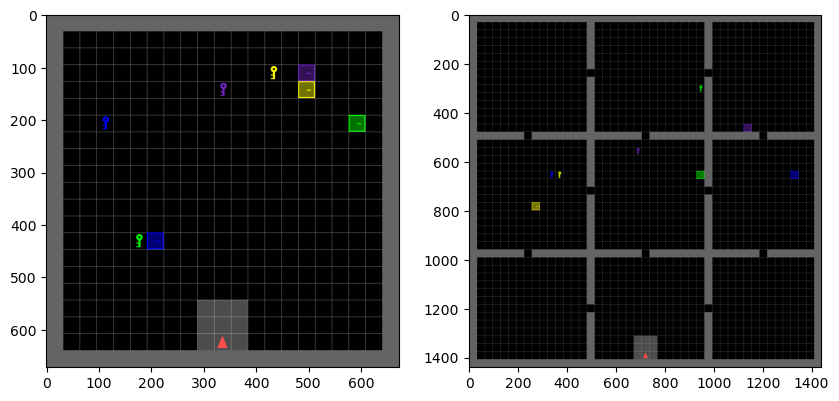

In [3]:
fig = plt.figure(figsize=(10, 5))

env = MultiGoalsEnv(render_mode = "rgb_array",
                    agent_goal=0, agent_view_size=3, 
                    agent_start_pos=(GRID_SIZE//2, GRID_SIZE-2), agent_start_dir=3,
                    size=GRID_SIZE)
_ = env.reset()

fig.add_subplot(1,2,1)
plt.imshow(env.render())

env_demo = MultiRoomsGoalsEnv(render_mode = "rgb_array",
                    agent_goal=0, agent_view_size=3, 
                    agent_start_pos=(GRID_SIZE_DEMO//2, GRID_SIZE_DEMO-2), agent_start_dir=3,
                    size=GRID_SIZE_DEMO)
_ = env_demo.reset()

fig.add_subplot(1,2,2)
plt.imshow(env_demo.render());

## Learner (Bayesian - RL)

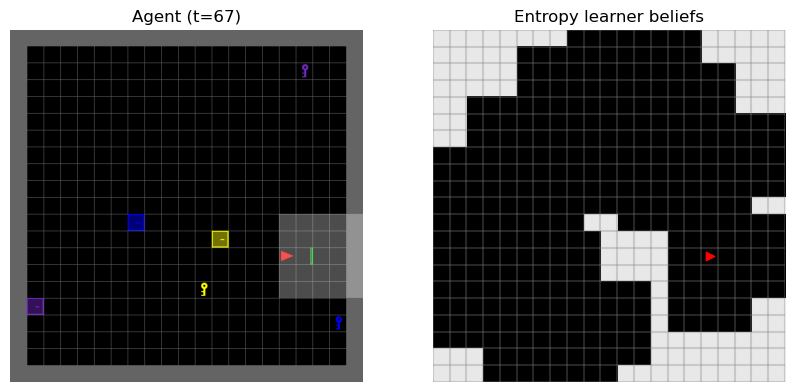

In [7]:
receptive_field = 5
goal_color = 0

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE, env_type='MultiGoalsEnv') #, save_render=True)
images = display_learner_play(GRID_SIZE, learner)

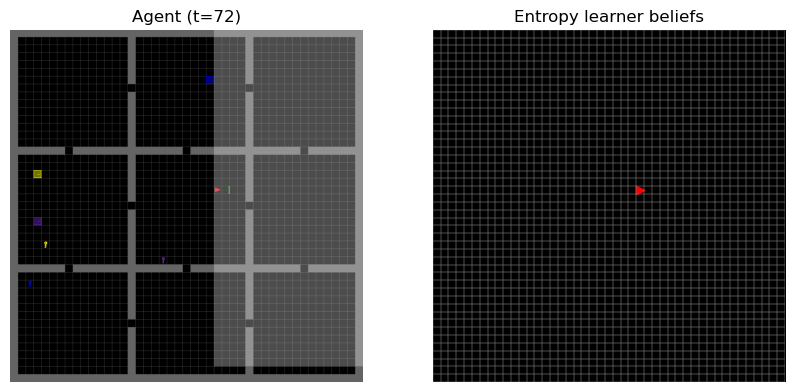

In [12]:
receptive_field = GRID_SIZE_DEMO
goal_color = 0

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE_DEMO, env_type='MultiRoomsGoalsEnv') #, save_render=True)
images = display_learner_play(GRID_SIZE_DEMO, learner)

In [13]:
receptive_field = 7
goal_color = 1

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE_DEMO, env_type='MultiRoomsGoalsEnv')
learner.play()

print(f' Learner with rf={receptive_field} for goal_color={goal_color} ({IDX_TO_COLOR[goal_color+1]}) \n \
      Step count: {learner.env.step_count} (max_steps={learner.env.max_steps}) \n \
      Reward: {learner.reward:.4f}')

 Learner with rf=7 for goal_color=1 (blue) 
       Step count: 324 (max_steps=1012) 
       Reward: 0.7119


In [17]:
learner.reset()
learner.play()

print(f' Learner with rf={receptive_field} for goal_color={goal_color} ({IDX_TO_COLOR[goal_color+1]}) \n \
      Step count: {learner.env.step_count} (max_steps={learner.env.max_steps}) \n \
      Reward: {learner.reward:.4f}')

 Learner with rf=7 for goal_color=1 (blue) 
       Step count: 624 (max_steps=1012) 
       Reward: 0.4451


### Statistics on different learners

In [12]:
# Paremeters

GRID_SIZE = 15
N = 200

env_type = 'MultiRoomsGoalsEnv'

if env_type =='MultiGoalsEnv':
    grid_size = GRID_SIZE
    rf_values = rf_values_basic + [GRID_SIZE]
    
elif env_type == 'MultiRoomsGoalsEnv':
    grid_size = GRID_SIZE_DEMO
    rf_values = rf_values_basic + [GRID_SIZE_DEMO]

print(f'Environment {env_type} \n \
      grid_size {grid_size} \n \
      rf_values {rf_values}')

Environment MultiRoomsGoalsEnv 
       grid_size 45 
       rf_values [3, 5, 7, 45]


In [13]:
mean_reward_all = np.zeros((num_colors, len(rf_values)))
std_reward_all = np.zeros((num_colors, len(rf_values)))

mean_count_all = np.zeros((num_colors, len(rf_values)))
std_count_all = np.zeros((num_colors, len(rf_values)))

for goal_color in range(num_colors):
    for ii,receptive_field in enumerate(rf_values):
        rewards_all = []
        counts_all = []
        for _ in trange(N):
            learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=grid_size, env_type=env_type)
            learner.play()
            
            # if learner.reward == 0:
            #     # assert(False)
            #     print(f'Exceed max_steps={learner.env.max_steps}')
            # Stats
            rewards_all.append(learner.reward)
            counts_all.append(learner.env.step_count)

        mean_reward_all[goal_color, ii] = np.mean(rewards_all)
        std_reward_all[goal_color, ii] = 1.96 * np.std(rewards_all) / np.sqrt(N)

        mean_count_all[goal_color, ii] = np.mean(counts_all)
        std_count_all[goal_color, ii] = 1.96 * np.std(counts_all) / np.sqrt(N)

100%|██████████| 200/200 [04:32<00:00,  1.36s/it]


In [ ]:
# # Save frames
# gif_file = f"./outputs_rendering/bug/output.gif"
# pil_images = [Image.fromarray(image.astype('uint8'), 'RGB') for image in learner.render_frames]
# pil_images[0].save(gif_file, save_all=True, append_images=pil_images[1:], duration=100, loop=0)

# # Save associeted beliefs entropy
# gif_file = f"./outputs_rendering/bug/output_belief.gif"
# pil_images = [Image.fromarray(image / (Shannon_entropy( 1 / 4 * np.ones(4)) + 0.5) * 255) for image in learner.render_beliefs]
# pil_images[0].save(gif_file, save_all=True, append_images=pil_images[1:], duration=100, loop=0)

In [14]:
import pandas as pd

mean_std_reward = np.zeros((num_colors, len(rf_values))).astype(str)

for g in range(num_colors):
    for ii,rf in enumerate(rf_values):
        mean_std_reward[g, ii] = str(np.round(mean_reward_all[g, ii], 4)) + " +/- " + str(np.round(std_reward_all[g, ii], 4))

df_reward = pd.DataFrame(mean_std_reward, columns=np.array(rf_values).astype('str'), index=['Green', 'Blue', 'Purple', 'Yellow'])

mean_std_count = np.zeros((num_colors, len(rf_values))).astype(str)

for g in range(num_colors):
    for ii,rf in enumerate(rf_values):
        mean_std_count[g, ii] = str(np.round(mean_count_all[g, ii], 4)) + " +/- " + str(np.round(std_count_all[g, ii], 4))

df_count = pd.DataFrame(mean_std_count, columns=np.array(rf_values).astype('str'), index=['Green', 'Blue', 'Purple', 'Yellow'])

print("Reward per type of learner")
display(df_reward)
print("# of step to fininsh the task per type of learner")
display(df_count)

Reward per type of learner


,3,5,7,45
Green,0.0555 +/- 0.0234,0.0982 +/- 0.0336,0.3243 +/- 0.0525,0.9297 +/- 0.0024
Blue,0.0462 +/- 0.0214,0.1478 +/- 0.0398,0.308 +/- 0.0515,0.9332 +/- 0.0024
Purple,0.05 +/- 0.0237,0.1331 +/- 0.0382,0.3185 +/- 0.0517,0.9313 +/- 0.0028
Yellow,0.0339 +/- 0.02,0.1296 +/- 0.0376,0.3386 +/- 0.0523,0.9302 +/- 0.0026


# of step to fininsh the task per type of learner


,3,5,7,45
Green,963.11 +/- 21.9936,920.1 +/- 32.5946,699.03 +/- 51.8766,79.0 +/- 2.7157
Blue,971.305 +/- 19.9466,872.845 +/- 38.792,716.825 +/- 50.9737,75.11 +/- 2.7163
Purple,966.98 +/- 22.7173,887.085 +/- 37.2033,703.86 +/- 50.8473,77.255 +/- 3.1447
Yellow,981.185 +/- 19.1996,889.375 +/- 36.3751,684.63 +/- 51.4723,78.535 +/- 2.9379


In [15]:
mean_std_reward = np.zeros(len(rf_values)).astype(str)

for ii,rf in enumerate(rf_values):
    mean_std_reward[ii] = str(np.round(np.mean(mean_reward_all[:, ii]), 4)) + " +/- " + str(np.round(np.mean(std_reward_all[:, ii]), 4))

df_reward = pd.DataFrame(mean_std_reward.reshape((1,4)), columns=np.array(rf_values).astype('str'), index=['learner'])

mean_std_count = np.zeros(len(rf_values)).astype(str)

for ii,rf in enumerate(rf_values):
    mean_std_count[ii] = str(np.round(np.mean(mean_count_all[:, ii]), 4)) + " +/- " + str(np.round(np.mean(std_count_all[:, ii]), 4))

df_count = pd.DataFrame(mean_std_count.reshape((1,4)), columns=np.array(rf_values).astype('str'), index=['learner'])

print("Reward per RF")
display(df_reward)
print("# of step to fininsh the task per RF")
display(df_count)

Reward per RF


,3,5,7,45
learner,0.0464 +/- 0.0222,0.1272 +/- 0.0373,0.3224 +/- 0.052,0.9311 +/- 0.0026


# of step to fininsh the task per RF


,3,5,7,45
learner,970.645 +/- 20.9643,892.3512 +/- 36.2413,701.0863 +/- 51.2924,77.475 +/- 2.8786


## Bayesian teacher

### Teacher knowing rational learner AND its strategies
 - Greedy: follow the shortest path computed by A* algo to the object (goal or subgoal)
 - Exploration: active exploration, take the action that minimizes the global uncertainty on the env i.e. that maximizes the discovery

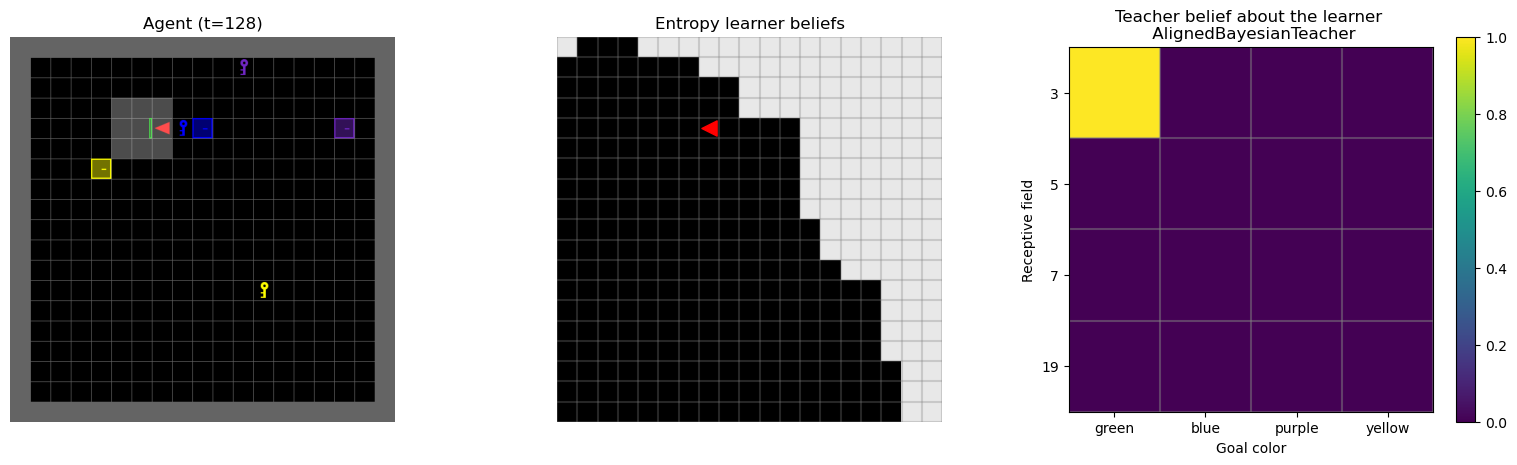

In [8]:
GRID_SIZE = 19

receptive_field = 3
goal_color = 0

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE) #, save_render=True)
teacher = AlignedBayesianTeacher(env=learner.env)
print(teacher.rf_values)
images = display_learner_play_teacher_infer(GRID_SIZE, learner, teacher)

## Save gif
# gif_file = f"./outputs_rendering/bug/rendering_rf_{receptive_field}.gif"
# images[0].save(gif_file, save_all=True, append_images=images[1:], duration=200, loop=0)

In [28]:
# Debugging
save_LOG("./outputs_rendering/bug/LOG_teacher.csv", teacher)
save_LOG("./outputs_rendering/bug/LOG_learner.csv", learner)

#### Satistics on the ToM model
- The teacher observes the entire episode (i.e. until the learner finishes the task)
- The ambiguity at the end of the episode is on the size of the receptive field
    - The evaluation metric of the ToM model is the accuracy on the size of the receptive field of the MAP}}$ of the teacher beliefs

In [9]:
grid_size_values = [11, 15, 21, 25]

DICT = {}
N = 10

In [11]:
# Progress bar
print(f'Progress aligned Bayesian teacher:', end='\n')
pbar = progressbar.ProgressBar(maxval=len(grid_size_values) * len(rf_values) * num_colors * N).start()
nn = 0

for kk,GRID_SIZE in enumerate(grid_size_values):
    dict = {}

    rf_values = np.array(rf_values_basic + [GRID_SIZE])

    for rf_idx,receptive_field in enumerate(rf_values):
        dict[receptive_field] = {}
        for goal_color in range(num_colors):
            dict[receptive_field][goal_color] = {}

            dict[receptive_field][goal_color]['accuracy'] = {}
            dict[receptive_field][goal_color]['accuracy']['goal'] = []
            dict[receptive_field][goal_color]['accuracy']['rf'] = []

            dict[receptive_field][goal_color]['length'] = []
            dict[receptive_field][goal_color]['beliefs'] = []
            for _ in range(N):
                learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE)
                teacher = AlignedBayesianTeacher(env=learner.env, rf_values=rf_values)

                ii = 0
                while not learner.terminated: # and ii < 1:
                    
                    # Interaction
                    agent_pos = learner.env.agent_pos
                    agent_dir = learner.env.agent_dir
                    teacher.update_knowledge(learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii)
                    traj = learner.play(size=1)
                    teacher.observe(action=traj[0])

                    assert(not np.isnan(teacher.beliefs[0, 0]))

                    ii += 1

                argmax_set = np.where(teacher.beliefs == np.max(teacher.beliefs))
                argmax_idx = np.random.choice(len(argmax_set[0]))
                argmax = np.array([argmax_set[0][argmax_idx], argmax_set[1][argmax_idx]])

                dict[receptive_field][goal_color]['accuracy']['goal'].append(goal_color == argmax[0])
                dict[receptive_field][goal_color]['accuracy']['rf'].append(rf_idx == argmax[1])
                dict[receptive_field][goal_color]['length'].append(ii)
                dict[receptive_field][goal_color]['beliefs'].append(teacher.beliefs)
                
                # Progress bar
                nn += 1
                pbar.update(nn)

    DICT[GRID_SIZE] = dict
    
    # Save dict
    with open(f'./stats/20.07.2023/aligned/stats_outputs_aligned.pickle', 'wb') as f:
        pickle.dump(DICT, f)

Progress aligned Bayesian teacher:


In [9]:
# Debugging
save_LOG("./outputs_rendering/bug/LOG_teacher.csv", teacher)
save_LOG("./outputs_rendering/bug/LOG_learner.csv", learner)

### Teacher knowing rational learner
 - Greedy: get closer to the object (goal or subgoal)
 - Exploration: uniform on the mouvement actions

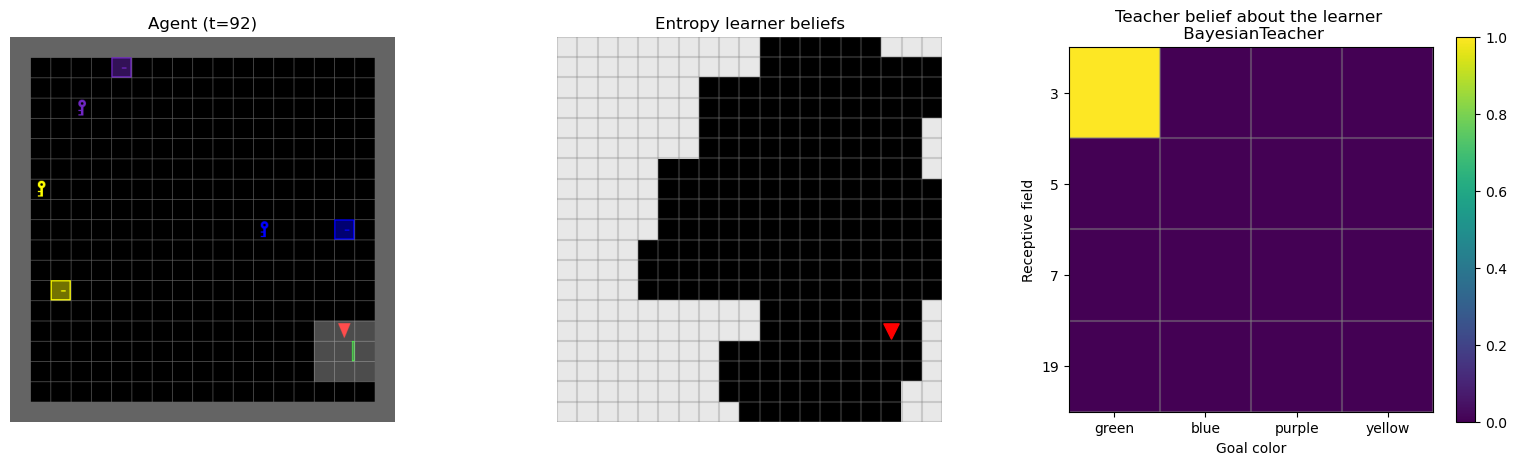

In [9]:
from IPython.display import clear_output
from PIL import Image

GRID_SIZE = 19

receptive_field = 3
goal_color = 0
lambd = 0.1

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE) #, save_render=True)
teacher = BayesianTeacher(env=learner.env, lambd=lambd)

images = display_learner_play_teacher_infer(GRID_SIZE, learner, teacher)

## Save gif
# gif_file = f"./outputs_rendering/bug/rendering_rf_{receptive_field}.gif"
# images[0].save(gif_file, save_all=True, append_images=images[1:], duration=200, loop=0)

In [ ]:
# Debugging
save_LOG("./outputs_rendering/bug/LOG_teacher.csv", teacher)
save_LOG("./outputs_rendering/bug/LOG_learner.csv", learner)

### Stats 

In [4]:
grid_size_values = [11, 15, 21, 25]
lamd_values = [0.01, 0.1, 0.5, 1., 3., 10.]

N = 200

In [ ]:
for lambd in lamd_values:

    DICT = {}

    # Progress bar
    print(f'Progress lambda={lambd}:', end='\n')
    pbar = progressbar.ProgressBar(maxval=len(grid_size_values) * len(RF_VALUES) * num_colors * N).start()
    nn = 0

    for kk,GRID_SIZE in enumerate(grid_size_values):
        dict = {}

        rf_values = np.array(rf_values_basic + [GRID_SIZE])

        for rf_idx,receptive_field in enumerate(rf_values):
            dict[receptive_field] = {}
            for goal_color in range(num_colors):
                dict[receptive_field][goal_color] = {}

                dict[receptive_field][goal_color]['accuracy'] = {}
                dict[receptive_field][goal_color]['accuracy']['goal'] = []
                dict[receptive_field][goal_color]['accuracy']['rf'] = []

                dict[receptive_field][goal_color]['length'] = []
                dict[receptive_field][goal_color]['beliefs'] = []
                for _ in range(N):
                    learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE)
                    teacher = BayesianTeacher(env=learner.env, rf_values=rf_values,lambd=lambd)

                    ii = 0
                    while not learner.terminated: # and ii < 1:
                        
                        # Interaction
                        agent_pos = learner.env.agent_pos
                        agent_dir = learner.env.agent_dir
                        teacher.update_knowledge(learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii)
                        traj = learner.play(size=1)
                        teacher.observe(action=traj[0])

                        assert(not np.isnan(teacher.beliefs[0, 0]))

                        ii += 1

                    argmax_set = np.where(teacher.beliefs == np.max(teacher.beliefs))
                    argmax_idx = np.random.choice(len(argmax_set[0]))
                    argmax = np.array([argmax_set[0][argmax_idx], argmax_set[1][argmax_idx]])

                    dict[receptive_field][goal_color]['accuracy']['goal'].append(goal_color == argmax[0])
                    dict[receptive_field][goal_color]['accuracy']['rf'].append(rf_idx == argmax[1])
                    dict[receptive_field][goal_color]['length'].append(ii)
                    dict[receptive_field][goal_color]['beliefs'].append(teacher.beliefs)
                    
                    # Progress bar
                    nn += 1
                    pbar.update(nn)

        DICT[GRID_SIZE] = dict
        
        # Save dict
        with open(f'./stats/20.07.2023/lambda_{lambd}/stats_outputs_lambd_{lambd}.pickle', 'wb') as f:
            pickle.dump(DICT, f)



#### Display ToM model analysis

In [ ]:
# Parameters for display
for lambd in lamd_values: 
    for GRID_SIZE in grid_size_values:

        load_filename = f'./stats/lambda_{lambd}/stats_outputs_lambd_{lambd}.pickle'
        save_filename = f'./stats/lambda_{lambd}/analysis_gridsize_{GRID_SIZE}.png'

        display_ToM_hist(GRID_SIZE, load_filename, save_filename, N, lambd)

        save_filename = f'./stats/lambda_{lambd}/all_acc_lambda_{lambd}.png'
        display_ToM_errorbar(load_filename, save_filename, lambd)

### Display all ToM models performances (RF-accuracy MAP)

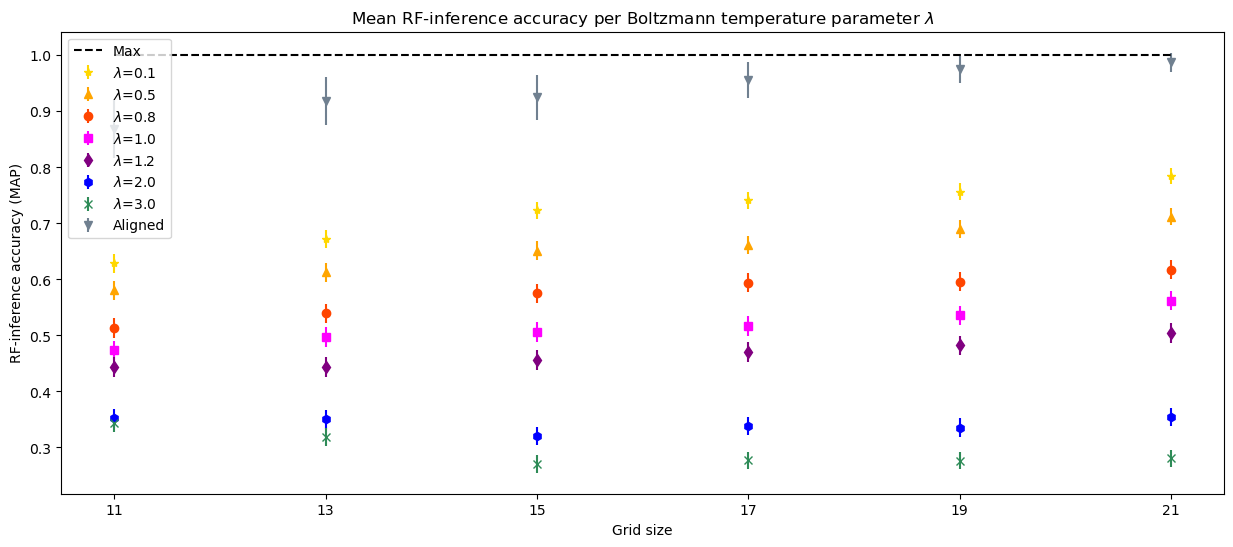

In [6]:
display_all_ToM(lamd_values, grid_size_values)

## Demonstrations

In [ ]:
dict = {}
N = 100

# for GRID_SIZE in grid_size_values:
dict[GRID_SIZE_DEMO] = {}

rf_values = rf_values_basic + [GRID_SIZE_DEMO]

all_length = [[] for _ in rf_values]

for rf_idx,rf in enumerate(rf_values):
    for goal_color in trange(num_colors):
        for _ in range(N):
            # Generate new feasible env
            learner = BayesianLearner(goal_color=goal_color, receptive_field=rf, grid_size=GRID_SIZE_DEMO, env_type='MultiRoomsGoalsEnv')
            env = learner.env

            traj = generate_demo(env, rf, goal_color)
            all_length[rf_idx].append(len(traj))

mean_all = [np.mean(length) for length in all_length]
std_all = [np.std(length) for length in all_length]

dict[GRID_SIZE]['mean'] = mean_all
dict[GRID_SIZE]['std'] = std_all


In [ ]:
grid_size_values= [GRID_SIZE_DEMO]
mean_std_length = np.zeros((len(grid_size_values), len(rf_values))).astype(str)

for gg, GRID_SIZE in enumerate(grid_size_values):
    for ii,rf in enumerate(rf_values):
        mean = dict[GRID_SIZE]['mean'][ii]
        std = dict[GRID_SIZE]['std'][ii]
        mean_std_length[gg, ii] = str(np.round(mean, 4)) + " +/- " + str(np.round(1.96 * std / np.sqrt(N * num_colors), 4))

pd.DataFrame(mean_std_length, columns=(rf_values_basic+['full_obs']), index=grid_size_values)

## Showing the demonstration

In [4]:
GRID_SIZE = 21
GRID_SIZE_DEMO = 45

print(f'MultiGoalsEnv observation nvironment: \n \
      GRID_SIZE {GRID_SIZE}\n \
      (max_steps={GRID_SIZE**2}) \n')

print(f'MultiRoomsGoalsEnv demonstration environment: \n \
      GRID_SIZE {GRID_SIZE_DEMO}\n \
      (max_steps={GRID_SIZE_DEMO**2/2}) \n')

idx = 1
receptive_field = RF_VALUES[idx]
goal_color = 0
print(f'Leaner: \n \
      rf={receptive_field} \n \
      goal_color={IDX_TO_COLOR[goal_color+1]} \n')

lambd = 0.1
print(f'Teacher: \n \
      Boltzmann temperatire lambda={lambd}')

rf_values_basic = [3, 5, 7]
rf_values = np.array(rf_values_basic + [GRID_SIZE])
rf_values_demo = np.array(rf_values_basic + [GRID_SIZE_DEMO])

MultiGoalsEnv observation nvironment: 
       GRID_SIZE 21
       (max_steps=441) 

MultiRoomsGoalsEnv demonstration environment: 
       GRID_SIZE 45
       (max_steps=1012.5) 

Leaner: 
       rf=5 
       goal_color=green 

Teacher: 
       Boltzmann temperatire lambda=0.1


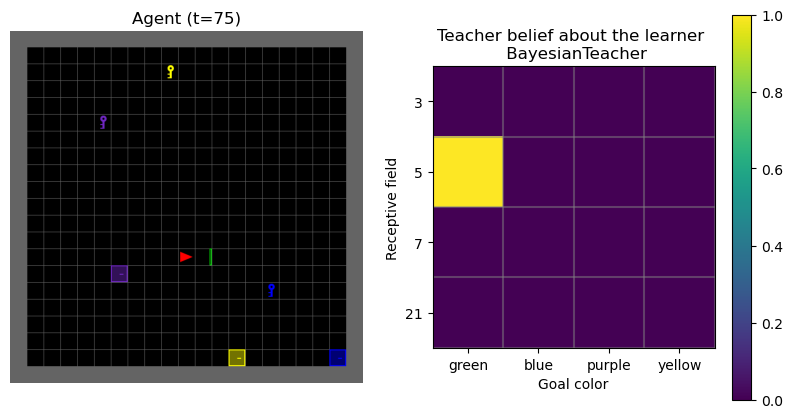

In [6]:
# Teacher observes the learner and fit his model

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE) #, save_render=True)
teacher = BayesianTeacher(env=learner.env, lambd=lambd)

images = display_learner_play_teacher_infer_blind(learner, teacher)

# gif_file = f"./outputs_rendering/demonstrations/example_1/observation_rf_{receptive_field}.gif"
# images[0].save(gif_file, save_all=True, append_images=images[1:], duration=200, loop=0)

In [7]:
learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE_DEMO, env_type='MultiRoomsGoalsEnv')
teacher.init_env(learner.env)

selected_demo, _, _, _ = teacher.select_demo()


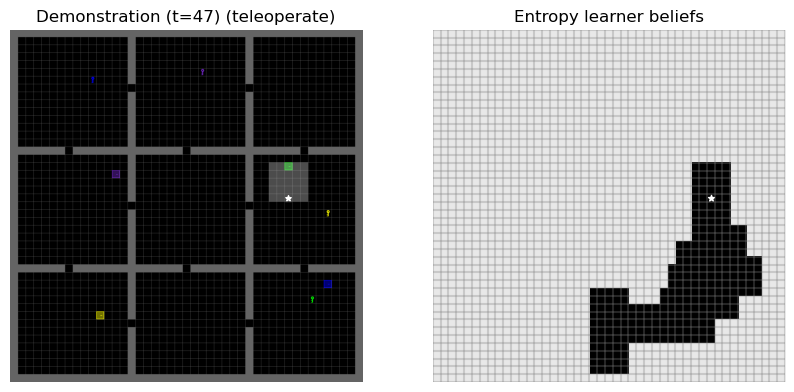

In [8]:
# Display demonstration and learner beliefs update

learner.observe(selected_demo)
images = display_learner_obs_demo(GRID_SIZE_DEMO, learner)

# gif_file = f"./outputs_rendering/demonstrations/example_1/demo_rf_{rf_values[demo_idx]}.gif"
# images[0].save(gif_file, save_all=True, append_images=images[1:], duration=200, loop=0)

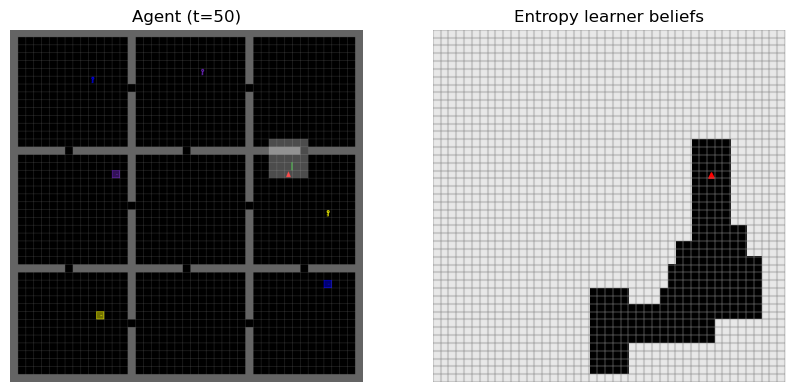

Reward: 0.9546


In [9]:
# Display learner playing after observing the demo

images = display_learner_play(GRID_SIZE_DEMO, learner, size=15)
print(f'Reward: {learner.reward:.4f}')

# gif_file = f"./outputs_rendering/demonstrations/example_1/play_after_demo_rf_{rf_values[demo_idx]}.gif"
# images[0].save(gif_file, save_all=True, append_images=images[1:], duration=200, loop=0)

### Statistics on the utility

In [11]:
N = 200
goal_color = 0

#### Stats on the predicted reward by the teachers of the learner after seen the demo on the $\mathbf{complex \text{ } env}$

In [6]:
all_reward = {} # np.zeros((len(rf_values), len(rf_values)))

for rf_idx,receptive_field in enumerate(RF_VALUES_DEMO):
        for demo_idx,demo_rf in enumerate(RF_VALUES_DEMO):
             all_reward[rf_idx, demo_idx] = []

for _ in trange(N):
    learner = BayesianLearner(goal_color=goal_color, receptive_field=RF_VALUES_DEMO[0], grid_size=GRID_SIZE_DEMO, \
                              env_type='MultiRoomsGoalsEnv', max_steps=int(GRID_SIZE_DEMO**2/2))
    teacher = AlignedBayesianTeacher(learner.env)
    for rf_idx,receptive_field in enumerate(RF_VALUES_DEMO):
        for demo_idx,demo_rf in enumerate(RF_VALUES_DEMO):
            
            # Reset env
            learner.reset()
            learner.change_receptive_field(receptive_field)

            # Generate demo for predicted rf demo_rf (right goal_color)
            demo = generate_demo(learner.env, demo_rf, goal_color)
            
            pred_reward = teacher.predicted_reward(demo, goal_color, rf_idx)

            all_reward[rf_idx, demo_idx].append(pred_reward)

100%|██████████| 200/200 [55:23<00:00, 16.62s/it]


In [9]:
all_reward_mean = np.zeros((len(RF_VALUES_DEMO), len(RF_VALUES_DEMO)))

for rf_idx, rf in enumerate(RF_VALUES_DEMO):
    for demo_idx, rf_demo in enumerate(RF_VALUES_DEMO):
        all_reward_mean[rf_idx, demo_idx] = np.mean(all_reward[rf_idx, demo_idx])

save_filename = f'./stats/reward/predicted_reward_{teacher.__class__.__name__}.pickle'
with open(save_filename, 'wb') as f:
        pickle.dump(all_reward_mean, f)

In [38]:
load_filename = f'./stats/reward/predicted_reward_{teacher.__class__.__name__}.pickle'

with open(load_filename, 'rb') as f:
    all_reward_mean = pickle.load(f)

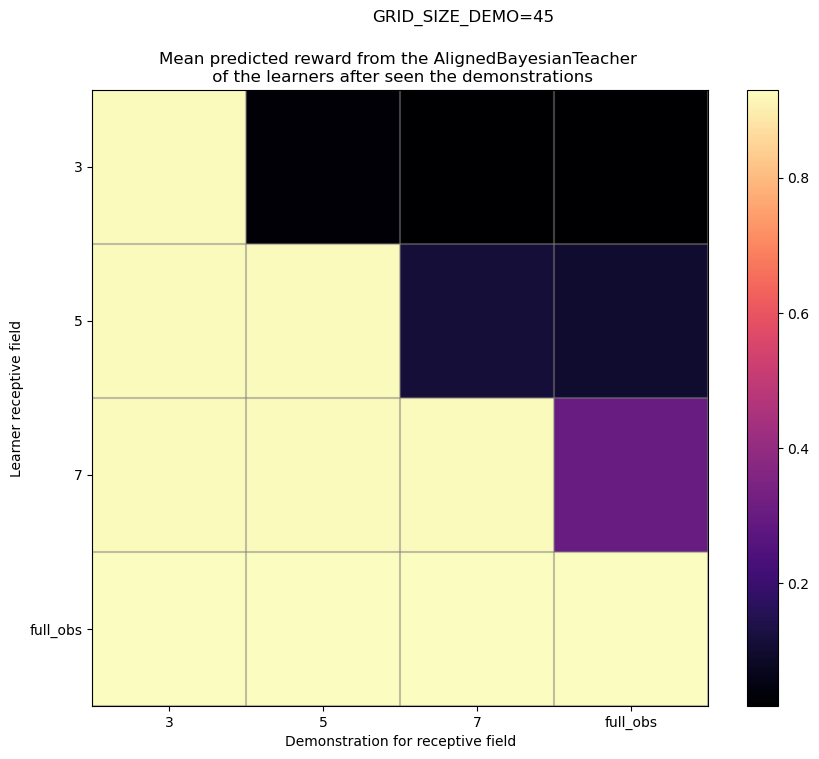

In [8]:
fig = plt.figure(figsize=(10, 8))

image = plt.imshow(all_reward_mean, cmap='magma')
plt.colorbar(image)
plt.xticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ['full_obs'])
plt.yticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ['full_obs'])
plot_grid(-.5, 5, 3.5)
plt.title(f'Mean predicted reward from the {teacher.__class__.__name__} \n of the learners after seen the demonstrations')# \n lambda={lambd}')
plt.ylabel('Learner receptive field')
plt.xlabel('Demonstration for receptive field')


fig.suptitle(f'GRID_SIZE_DEMO={GRID_SIZE_DEMO}');

#### Stats on the true utility --> run of the learner

In [12]:
all_steps_count = {} # np.zeros((len(rf_values), len(rf_values)))
all_reward = {} # np.zeros((len(rf_values), len(rf_values)))
all_length = {} # np.zeros((len(rf_values), len(rf_values)))

for rf_idx,receptive_field in enumerate(RF_VALUES_DEMO):
        for demo_idx,demo_rf in enumerate(RF_VALUES_DEMO):
             all_steps_count[rf_idx, demo_idx] = []
             all_reward[rf_idx, demo_idx] = []
             all_length[rf_idx, demo_idx] = []

for _ in trange(N):
    learner = BayesianLearner(goal_color=goal_color, receptive_field=RF_VALUES_DEMO[0], grid_size=GRID_SIZE_DEMO, 
                              env_type='MultiRoomsGoalsEnv', max_steps=int(GRID_SIZE_DEMO**2/2))
    for rf_idx,receptive_field in enumerate(RF_VALUES_DEMO):
        for demo_idx,demo_rf in enumerate(RF_VALUES_DEMO):
            
            # Reset env
            learner.reset()
            learner.change_receptive_field(receptive_field)

            # Generate demo for predicted rf demo_rf (right goal_color)
            demo = generate_demo(learner.env, demo_rf, goal_color)
            
            # Learner observes the demonstration
            learner.observe(demo)

            # Reset step count in the env
            learner.env.step_count = 0
            # Learner play after observing the demo
            learner.play()

            all_steps_count[rf_idx, demo_idx].append(learner.env.step_count)
            all_reward[rf_idx, demo_idx].append(learner.reward)
            all_length[rf_idx, demo_idx].append(len(demo))

100%|██████████| 200/200 [1:14:41<00:00, 22.41s/it]


In [13]:
DICT_DEMO = dict(all_length=all_length,
                 all_reward=all_reward,
                 all_steps_count=all_steps_count)

save_filename = f'./stats/true_utility/stats_outputs_complex_env_without_exploration_goal.pickle'
with open(save_filename, 'wb') as f:
        pickle.dump(DICT_DEMO, f)

In [20]:
# Load dico

load_filename = f'./stats/true_utility/stats_outputs_complex_env_without_exploration_goal.pickle'
with open(load_filename, 'rb') as f:
    DICT_DEMO = pickle.load(f)

In [48]:
all_steps_count_mean = np.zeros((len(RF_VALUES_DEMO), len(RF_VALUES_DEMO)))
all_length_mean = np.zeros((len(RF_VALUES_DEMO), len(RF_VALUES_DEMO)))
all_reward_mean = np.zeros((len(RF_VALUES_DEMO), len(RF_VALUES_DEMO)))
all_utilities_mean = np.zeros((len(RF_VALUES_DEMO), len(RF_VALUES_DEMO)))

alpha= 0.3
def cost(a, norm):
    return alpha * np.exp( - (norm - a) * alpha) - alpha * np.exp(- norm * alpha)

# alpha = 0.15
# def cost(a, norm=None):
#     assert(np.all(a <= norm))
#     return alpha * a / norm

for rf_idx, rf in enumerate(rf_values_demo):
    for demo_idx, rf_demo in enumerate(rf_values_demo):
        all_steps_count_mean[rf_idx, demo_idx] = np.mean(DICT_DEMO['all_steps_count'][rf_idx, demo_idx])

        n = 0

        all_reward_mean[rf_idx, demo_idx] = np.mean(DICT_DEMO['all_reward'][rf_idx, demo_idx][:N])
        all_length_mean[rf_idx, demo_idx] = np.mean(DICT_DEMO['all_length'][rf_idx, demo_idx][:N])

        norm = np.max(np.array([DICT_DEMO['all_length'][rf_idx, ii][:N] for ii,_ in enumerate(rf_values_demo)]), axis=0)
        all_utilities_mean[rf_idx, demo_idx] = np.mean(np.array(DICT_DEMO['all_reward'][rf_idx, demo_idx][:N]) -  cost(np.array(DICT_DEMO['all_length'][rf_idx, demo_idx][:N]), norm))


In [49]:
for rf_idx, rf in enumerate(rf_values_demo):
    score = 0
    for n in range(N):
        # n = sample
        norm = np.max(np.array([DICT_DEMO['all_length'][rf_idx, ii][n] for ii,_ in enumerate(rf_values_demo)]))
        utility = np.array([DICT_DEMO['all_reward'][rf_idx, ii][n] -  cost(np.array(DICT_DEMO['all_length'][rf_idx, ii][n]), norm) for ii,_ in enumerate(rf_values_demo)])
        
        argmax_idx = np.argmax(utility)
        score += argmax_idx == rf_idx
        
    score /= N
    print(f'rf={rf} --> score {score}')


rf=3 --> score 0.955
rf=5 --> score 0.925
rf=7 --> score 0.9
rf=45 --> score 1.0


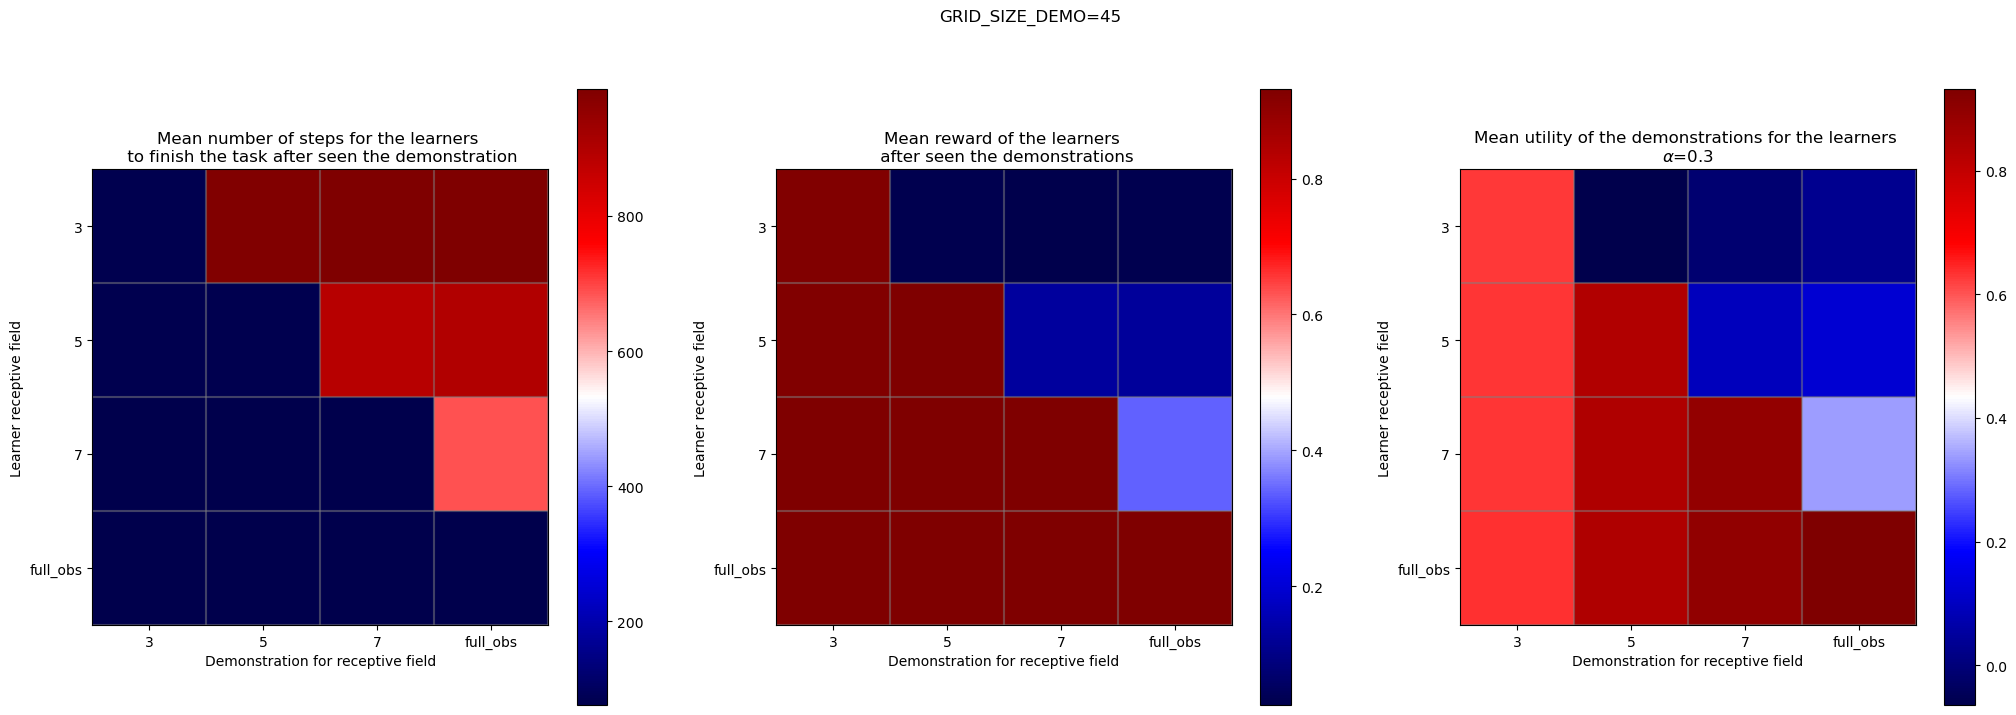

In [50]:
fig = plt.figure(figsize=(25, 8))

fig.add_subplot(1,3,1)
image = plt.imshow(all_steps_count_mean, cmap='seismic')
plt.colorbar(image)
plt.xticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ['full_obs'])
plt.yticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ['full_obs'])
plot_grid(-.5, 5, 3.5)
plt.title('Mean number of steps for the learners \n to finish the task after seen the demonstration')
plt.ylabel('Learner receptive field')
plt.xlabel('Demonstration for receptive field')

fig.add_subplot(1,3,2)
image = plt.imshow(all_reward_mean, cmap='seismic')
plt.colorbar(image)
plt.xticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ['full_obs'])
plt.yticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ['full_obs'])
plot_grid(-.5, 5, 3.5)
plt.title('Mean reward of the learners \n after seen the demonstrations')
plt.ylabel('Learner receptive field')
plt.xlabel('Demonstration for receptive field')

fig.add_subplot(1,3,3)
image = plt.imshow(all_utilities_mean, cmap='seismic')
plt.colorbar(image)
plt.xticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ['full_obs'])
plt.yticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ['full_obs'])
plot_grid(-.5, 5, 3.5)
plt.title(f'Mean utility of the demonstrations for the learners \n' + fr'$\alpha$={alpha}')
plt.ylabel('Learner receptive field')
plt.xlabel('Demonstration for receptive field')


fig.suptitle(f'GRID_SIZE_DEMO={GRID_SIZE_DEMO}');

In [51]:
np.round(all_utilities_mean, 4)

array([[ 0.628 , -0.0644, -0.0118,  0.0296],
       [ 0.6291,  0.8345,  0.0929,  0.1247],
       [ 0.6296,  0.835 ,  0.8925,  0.3392],
       [ 0.6328,  0.8378,  0.8953,  0.932 ]])

In [32]:
all_reward_mean

array([[0.92725296, 0.02982806, 0.02499061, 0.02960277],
       [0.92832905, 0.92875593, 0.12962006, 0.12469565],
       [0.92884486, 0.92928953, 0.92928508, 0.33924555],
       [0.93201087, 0.93201087, 0.93201087, 0.93201087]])

In [60]:
all_length_mean

array([[64.87, 59.92, 54.65,  0.  ],
       [64.87, 59.92, 54.65,  0.  ],
       [64.87, 59.92, 54.65,  0.  ],
       [64.87, 59.92, 54.65,  0.  ]])

#### Cost functions

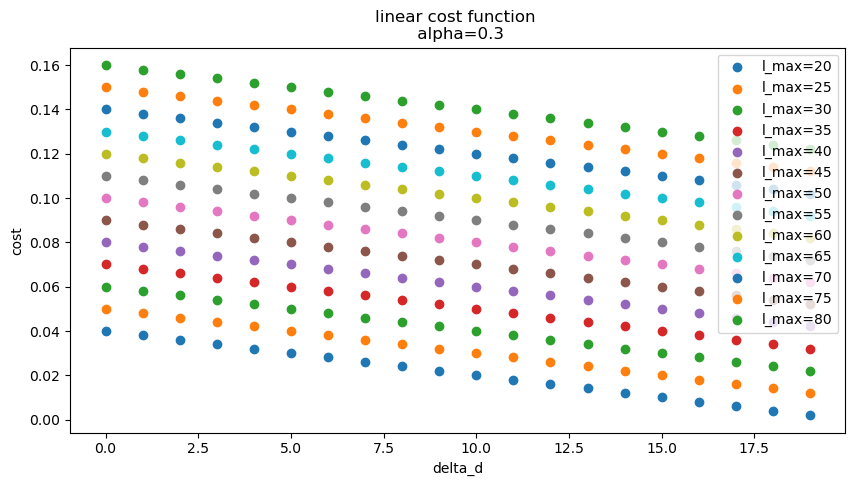

In [57]:
display_cost(linear)

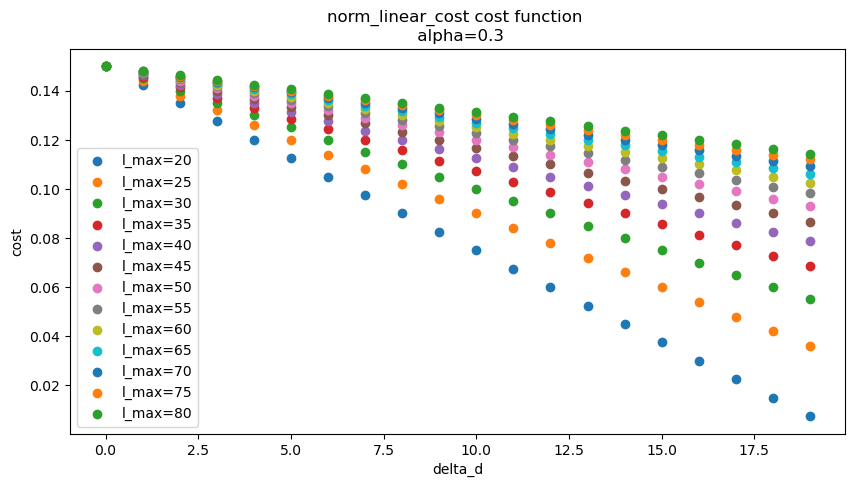

In [58]:
display_cost(norm_linear_cost)

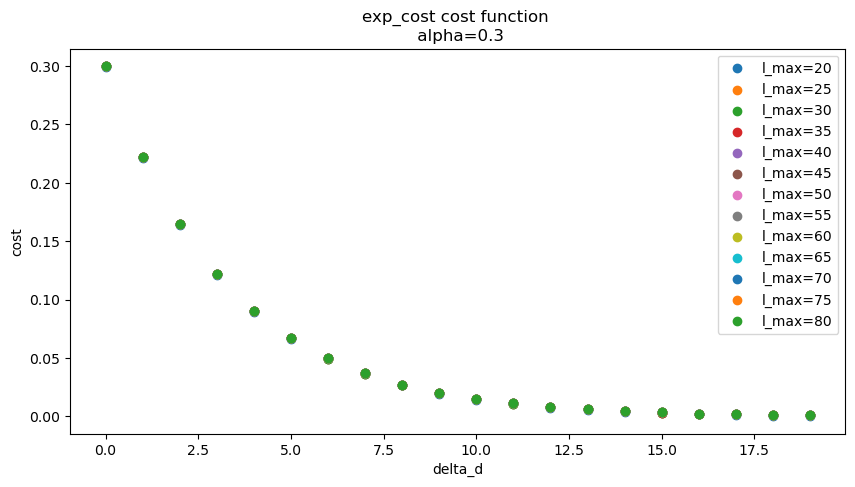

In [59]:
display_cost(exp_cost)

### Statistics on the utility of the teachers - Rationality Principle based / Aligned

In [5]:
GRID_SIZE = 21
GRID_SIZE_DEMO = 45

print(f'MultiGoalsEnv observation nvironment: \n \
      GRID_SIZE {GRID_SIZE}\n \
      (max_steps={GRID_SIZE**2}) \n')

print(f'MultiRoomsGoalsEnv demonstration environment: \n \
      GRID_SIZE {GRID_SIZE_DEMO}\n \
      (max_steps={GRID_SIZE_DEMO**2/2}) \n')

idx = 1
receptive_field = RF_VALUES[idx]
goal_color = 0
print(f'Leaner: \n \
      rf={receptive_field} \n \
      goal_color={IDX_TO_COLOR[goal_color+1]} \n')

print(f'Teacher: \n \
      Boltzmann temperatire lambda={lambd}')

lambd = 0.1
rf_values_basic = [3, 5, 7]
rf_values = np.array(rf_values_basic + [GRID_SIZE])
rf_values_demo = np.array(rf_values_basic + [GRID_SIZE_DEMO])

MultiGoalsEnv observation nvironment: 
       GRID_SIZE 21
       (max_steps=441) 

MultiRoomsGoalsEnv demonstration environment: 
       GRID_SIZE 45
       (max_steps=1012.5) 

Leaner: 
       rf=5 
       goal_color=green 

Teacher: 
       Boltzmann temperatire lambda=0.1


In [6]:
N = 150

In [10]:
alpha = 0.3
def cost_fun(x: int, l: int) -> float:
    return exp_cost(x, l, alpha=alpha)

save_filename = f'./outputs/eval_utility/obs_{GRID_SIZE}_demo_{GRID_SIZE_DEMO}_exp_cost_{alpha}.pickle'

DICT_UTIL = {}
DICT_UTIL[lambd] = {}
DICT_UTIL['omniscient'] = {}
DICT_UTIL['aligned'] = {}
DICT_UTIL['opt_non_adaptive'] = {}

for rf_idx,receptive_field in enumerate(rf_values):
    for goal_color in range(num_colors):
        DICT_UTIL[lambd][goal_color, receptive_field] = []
        DICT_UTIL['aligned'][goal_color, receptive_field] = []
        DICT_UTIL['omniscient'][goal_color, receptive_field] = []
        DICT_UTIL['opt_non_adaptive'][goal_color, receptive_field] = []

        for _ in range(N):
            # print(f'Learner: rf={receptive_field} goal_color={IDX_TO_COLOR[goal_color+1]}')
            # Test teacher utility
            learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE, env_type='MultiGoalsEnv')
            teacher = BayesianTeacher(env=learner.env, lambd=lambd)
            aligned_teacher = AlignedBayesianTeacher(env=learner.env)

            # Teacher observes the learner during one full episode on the first simple env
            ii = 0
            while not learner.terminated:
                
                agent_pos = learner.env.agent_pos
                agent_dir = learner.env.agent_dir

                teacher.update_knowledge(learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii)
                aligned_teacher.update_knowledge(learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii)

                traj = learner.play(size=1)

                teacher.observe(action=traj[0])
                aligned_teacher.observe(action=traj[0])

                ii += 1

            # Teacher use ToM to predict the utility of each demo for this particular learner --> select the more relevant demo
            learner = BayesianLearner(goal_color=goal_color, receptive_field=rf_values_demo[rf_idx], grid_size=GRID_SIZE_DEMO, env_type='MultiRoomsGoalsEnv')

            ## Rationality principle teacher
            teacher.init_env(learner.env)
            selected_demo, demo_idx, predicted_best_utility, demos = teacher.select_demo(cost_fun)

            # Learner "observes" the demo
            learner.observe(selected_demo)

            # Reset step count in the env
            learner.env.step_count = 0
            # Learner play after seen the demo
            _ = learner.play()

            true_utility = learner.reward - cost_fun(len(selected_demo))

            DICT_UTIL[lambd][goal_color, receptive_field].append((demo_idx, predicted_best_utility, true_utility))
            # print(f'Bayesian teacher: selected demo: {demo_idx} predicted best utility: {predicted_best_utility:.4f} true utility: {true_utility:.4f}')

            ## Aligned teacher
            aligned_teacher.init_env(learner.env)
            aligned_selected_demo, aligned_demo_idx, aligned_predicted_best_utility, _ = aligned_teacher.select_demo(cost_fun)

            learner.reset()
            # Learner "observes" the demo
            learner.observe(aligned_selected_demo)

            # Reset step count in the env
            learner.env.step_count = 0
            # Learner play after seen the demo
            _ = learner.play()

            aligned_true_utility = learner.reward - cost_fun(len(aligned_selected_demo))

            DICT_UTIL['aligned'][goal_color, receptive_field].append((aligned_demo_idx, aligned_predicted_best_utility, aligned_true_utility))
            
            # print(f'Aligned teacher: selected demo: {aligned_demo_idx} predicted best utility: {aligned_predicted_best_utility:.4f} true utility: {aligned_true_utility:.4f}')

            ## Omnicient teacher
            true_utilities = []
            for demo in demos:
                # Reset env
                learner.reset()
                
                # Learner observes the demonstration
                learner.observe(demo)

                # Reset step count in the env
                learner.env.step_count = 0
                # Learner play after observing the demo
                learner.play()

                true_utility = learner.reward - cost_fun(len(demo))
                true_utilities.append(true_utility)
            
            true_best_utility = np.max(true_utilities)
            true_demo_idx = np.argmax(true_utilities)

            # print(f'Omniscient: best demo idx {true_demo_idx} true best utility {true_best_utility:.4f}')
            DICT_UTIL['omniscient'][goal_color, receptive_field].append((true_demo_idx, true_best_utility))
            
            ## Optimal non-adaptive
            DICT_UTIL['opt_non_adaptive'][goal_color, receptive_field].append((0, true_utilities[0]))

        with open(save_filename, 'wb') as f:
                pickle.dump(DICT_UTIL, f)

rf_idx 3 rf 21 goal_color 3


In [14]:
load_filename = f'./outputs/eval_utility/obs_{GRID_SIZE}_demo_{GRID_SIZE_DEMO}_exp_cost_{alpha}.pickle'

with open(load_filename, 'rb') as f:
    DICT_UTIL = pickle.load(f)

''

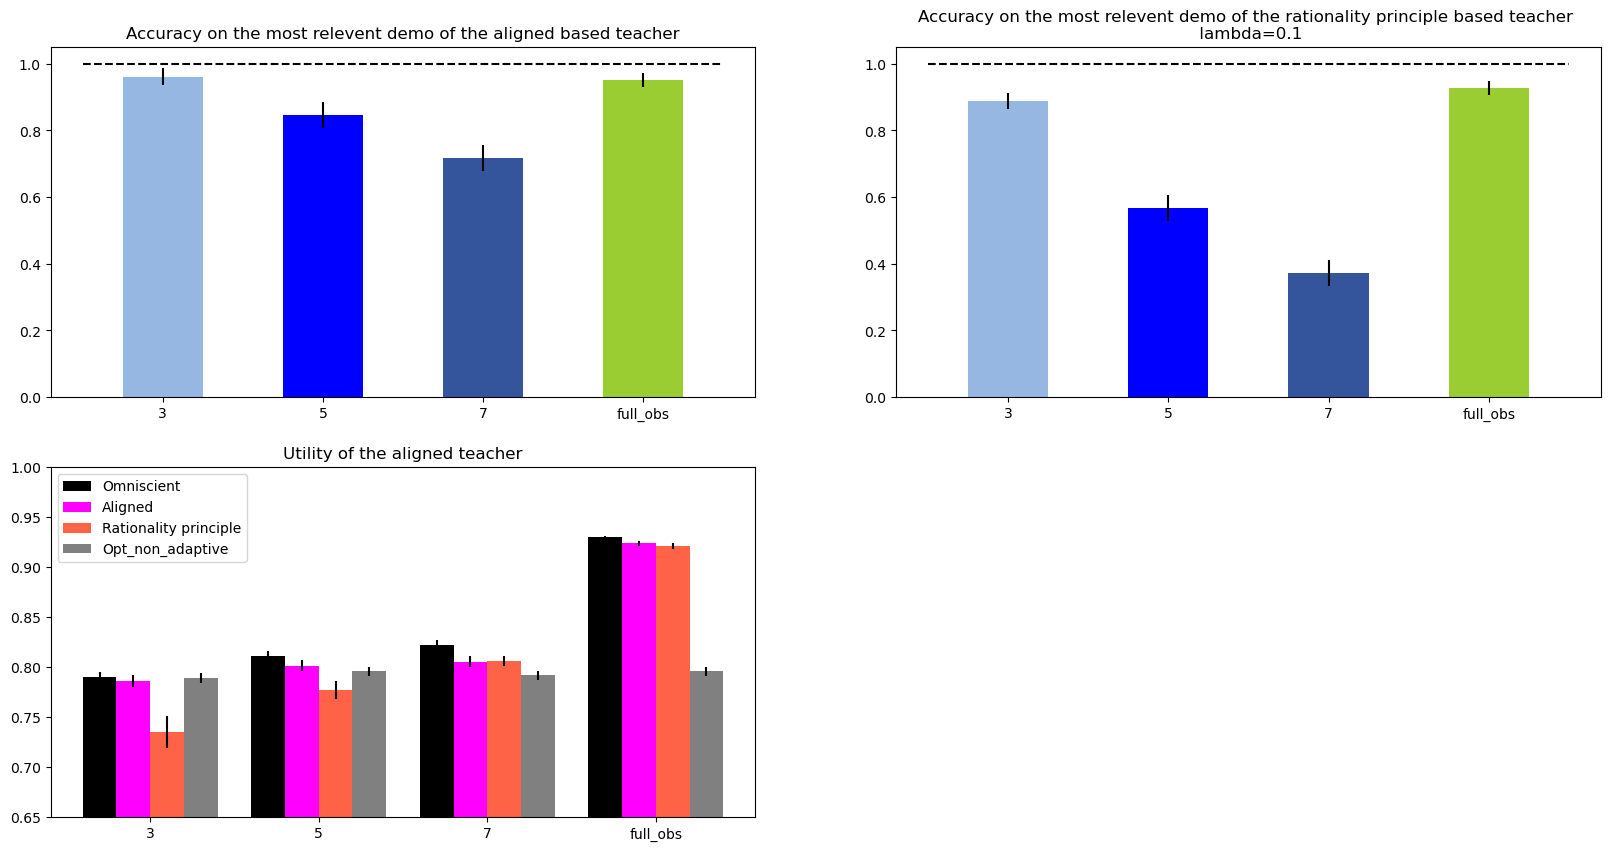

In [77]:
bayesien_all_utility_mean = []
bayesien_all_accuracy_demo_idx_mean = []
aligned_all_utility_mean = []
aligned_all_accuracy_demo_idx_mean = []
omniscient_all_utility_mean = []
opt_non_adaptive_all_utility_mean = []

bayesien_all_utility_std = []
bayesien_all_accuracy_demo_idx_std = []
aligned_all_utility_std = []
aligned_all_accuracy_demo_idx_std = []
omniscient_all_utility_std = []
opt_non_adaptive_all_utility_std = []

for rf_idx,receptive_field in enumerate(rf_values):
    bayesien_all_utility = []
    bayesien_all_accuracy_demo_idx = []

    aligned_all_utility = []
    aligned_all_accuracy_demo_idx = []

    omniscient_all_utility = []
    opt_non_adaptive_all_utility = []

    for goal_color in range(num_colors):
        
        bayesien_all_utility += list(np.array(DICT_UTIL[lambd][goal_color, receptive_field])[:, 2])
        bayesien_all_accuracy_demo_idx += list(np.array(DICT_UTIL[lambd][goal_color, receptive_field])[:, 0] == np.array(DICT_UTIL['omniscient'][goal_color, receptive_field])[:, 0])

        aligned_all_utility += list(np.array(DICT_UTIL['aligned'][goal_color, receptive_field])[:, 2])
        aligned_all_accuracy_demo_idx += list(np.array(DICT_UTIL['aligned'][goal_color, receptive_field])[:, 0] == np.array(DICT_UTIL['omniscient'][goal_color, receptive_field])[:, 0])

        # Baselines
        omniscient_all_utility += list(np.array(DICT_UTIL['omniscient'][goal_color, receptive_field])[:, 1])
        opt_non_adaptive_all_utility += list(np.array(DICT_UTIL['opt_non_adaptive'][goal_color, receptive_field])[:, 1])

    
    bayesien_all_utility_mean.append(np.mean(bayesien_all_utility))
    bayesien_all_accuracy_demo_idx_mean.append(np.mean(bayesien_all_accuracy_demo_idx))
    aligned_all_utility_mean.append(np.mean(aligned_all_utility))
    aligned_all_accuracy_demo_idx_mean.append(np.mean(aligned_all_accuracy_demo_idx))
    omniscient_all_utility_mean.append(np.mean(omniscient_all_utility))
    opt_non_adaptive_all_utility_mean.append(np.mean(opt_non_adaptive_all_utility))

    bayesien_all_utility_std.append(np.std(bayesien_all_utility))
    bayesien_all_accuracy_demo_idx_std.append(np.std(bayesien_all_accuracy_demo_idx))
    aligned_all_utility_std.append(np.std(aligned_all_utility))
    aligned_all_accuracy_demo_idx_std.append(np.std(aligned_all_accuracy_demo_idx))
    omniscient_all_utility_std.append(np.std(omniscient_all_utility))
    opt_non_adaptive_all_utility_std.append(np.std(opt_non_adaptive_all_utility))


fig = plt.figure(figsize=(20, 10))
colors = [np.array([149, 183, 226]) / 255, 'blue', np.array([52, 85, 156]) / 255, 'yellowgreen']

fig.add_subplot(2,2,1)
plt.title(f'Accuracy on the most relevent demo of the aligned based teacher')
plt.bar(np.array(rf_values_basic + ['full_obs']).astype(str), aligned_all_accuracy_demo_idx_mean, width=.5, yerr=1.96 * np.array(bayesien_all_accuracy_demo_idx_std) / np.sqrt(len(bayesien_all_accuracy_demo_idx)), color=colors, label=f'$\lambda$={lambd}')
plt.plot([-.5, 3.5], [1, 1], ls='--', c='k')

fig.add_subplot(2,2,2)
plt.title(f'Accuracy on the most relevent demo of the rationality principle based teacher \n lambda={lambd}')
plt.bar(np.array(rf_values_basic + ['full_obs']).astype(str), bayesien_all_accuracy_demo_idx_mean, width=.5, yerr=1.96 * np.array(bayesien_all_accuracy_demo_idx_std) / np.sqrt(len(bayesien_all_accuracy_demo_idx)), color=colors, label=f'$\lambda$={lambd}')
plt.plot([-.5, 3.5], [1, 1], ls='--', c='k')

fig.add_subplot(2, 2, 3)
plt.title(f'Utility of the aligned teacher')

bar_width = 0.2
x_pos = np.arange(len(np.array(rf_values_basic + ['full_obs']).astype(str)))

plt.bar(x_pos, omniscient_all_utility_mean, width=bar_width, align='center', yerr=1.96 * np.array(omniscient_all_utility_std) / np.sqrt(len(omniscient_all_utility)), color=['k']*4, label=f'Omniscient')
plt.bar(x_pos + bar_width, aligned_all_utility_mean, width=bar_width, align='center', yerr=1.96 * np.array(aligned_all_utility_std) / np.sqrt(len(aligned_all_utility)), color=['fuchsia']*4, label=f'Aligned')
plt.bar(x_pos + 2 * bar_width, bayesien_all_utility_mean, width=bar_width, align='center', yerr=1.96 * np.array(bayesien_all_utility_std) / np.sqrt(len(bayesien_all_utility)), color=['tomato']*4, label='Rationality principle')
plt.bar(x_pos + 3 * bar_width, opt_non_adaptive_all_utility_mean, width=bar_width, align='center', yerr=1.96 * np.array(opt_non_adaptive_all_utility_std) / np.sqrt(len(opt_non_adaptive_all_utility)), color=['gray']*4, label=f'Opt_non_adaptive')

plt.xticks(x_pos + 1.5 * bar_width, np.array(rf_values_basic + ['full_obs']).astype(str))
plt.ylim(0.65, 1)
plt.legend();

In [16]:
print(f'Model              Omniscient               Aligned           Rationality principle           Opt non adaptive')
print(f'Mean utility    {np.mean(omniscient_all_utility_mean):.4f} +/- {1.96 * np.sqrt(np.mean(np.array(omniscient_all_utility_std))) / np.sqrt(16*N):.4f} \
      {np.mean(aligned_all_utility_mean):.4f} +/- {1.96 * np.sqrt(np.mean(np.array(aligned_all_utility_std))) / np.sqrt(16*N):.4f} \
      {np.mean(bayesien_all_utility_mean):.4f} +/- {1.96 * np.sqrt(np.mean(np.array(bayesien_all_utility_std))) / np.sqrt(16*N):.4f} \
      {np.mean(opt_non_adaptive_all_utility_mean):.4f} +/- {1.96 * np.sqrt(np.mean(np.array(opt_non_adaptive_all_utility_std))) / np.sqrt(16*N):.4f}')

Model              Omniscient               Aligned           Rationality principle           Opt non adaptive
Mean utility    0.8383 +/- 0.0077       0.8291 +/- 0.0086       0.8099 +/- 0.0112       0.7933 +/- 0.0083
